In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cvxpy as cp

In [26]:
plt.rcParams['figure.figsize'] = (15, 5)

## Importing Necessary Data

In [2]:
df = pd.read_csv("C:/Users/vidis/OneDrive/Desktop/Spring23/BachelorProject/complete_dataset.csv")
ef = pd.read_csv("C:/Users/vidis/OneDrive/Desktop/Spring23/BachelorProject/Elspotprices.csv",sep=';',decimal=',')

In [3]:
df['Time'] = pd.to_datetime(df['Time'])
ef['HourDK'] = pd.to_datetime(ef['HourDK'])
mf = ef[ef['PriceArea']=='DK2'].merge(df,left_on='HourDK', right_on='Time')
prod = mf['prod_h16'].to_numpy()
cons = mf['cons_h16'].to_numpy()
prices = mf['SpotPriceDKK'].to_numpy()

In [4]:
def ccost(prod, cons, price, charge,sbr):
    surplus = prod-cons
    cost = []
    for i in range(len(surplus)):
        val = surplus[i] - charge[i]
        
        if (surplus[i]>=0) and (val>=0): # battery charged and excess sold
            cost.append(val*price[i]*sbr)
            
        elif (surplus[i]>=0) and (val<0): # battery charged and more bought
            cost.append(abs(val)*price[i])
            
        elif (surplus[i]<0) and (val>=0): # battery discharged and excess sold
            cost.append(val*price[i]*sbr)
        
        else: # battery discharged and more bought
            cost.append(abs(val)*price[i])
    
    cost = [np.sum(cost[:i]) for i in range(1,len(cost)+1)]
    
    return cost

In [5]:
def ccost_cvxpy(surplus, charge, price, sbr):
    cost = 0
    for i in range(len(surplus)):
        val = surplus[i] - charge[i] #  +ve charge = battery is being discharged, -ve charge = battery is being charged
        cost += cp.maximum(val, 0) * price[i] * sbr
        cost += cp.minimum(val, 0) * price[i] * -1.0
    return cost

In [37]:
import cvxpy as cp
import numpy as np

# Define problem parameters
num_steps = 24*5

start = 2500

consumption = cons[start:start+num_steps]
production = prod[start:start+num_steps] 
surplus = production - consumption
price = prices[:num_steps]/1000
sbr = 0.5

battery_capacity = 13
max_charge = 7

# Define optimization variables
battery_state = cp.Variable(num_steps + 1, nonneg=True)  # battery state of charge
charge = cp.Variable(num_steps, nonneg=False)  # battery charging/discharging rate

# Define objective function
objective = ccost_cvxpy(surplus, charge, price, sbr)

# Define constraints
constraints = [
    battery_state[0] == 0,
    battery_state <= battery_capacity,
    battery_state[1:] == battery_state[:-1] + charge,
    #-charge <= battery_state[:-1],  # discharging rate constraint
    charge <= max_charge,  # charging rate constraint
    -charge >= -max_charge,
]

    
# Define optimization problem
problem = cp.Problem(cp.Minimize(objective), constraints)

# Solve optimization problem
scipy_opts = {"solver": cp.OSQP}
problem.solve(verbose=True, **scipy_opts)

costs = [ccost_cvxpy(surplus[:i], charge[:i], price[:i],sbr).value for i in range(1,len(surplus)+1)]

print(f'Problem Status: {problem.status}')
print(f'Total Cost: {problem.value}')

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Mar 21 09:38:14 PM: Your problem has 241 variables, 5 constraints, and 0 parameters.
(CVXPY) Mar 21 09:38:14 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 21 09:38:14 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 21 09:38:14 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 21 09:38:14 PM: Compiling problem (target solver=OSQP).
(CVXPY) Mar 21 09:38:14 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffin

In [17]:
l = ccost(production, consumption, price, charge.value,sbr)

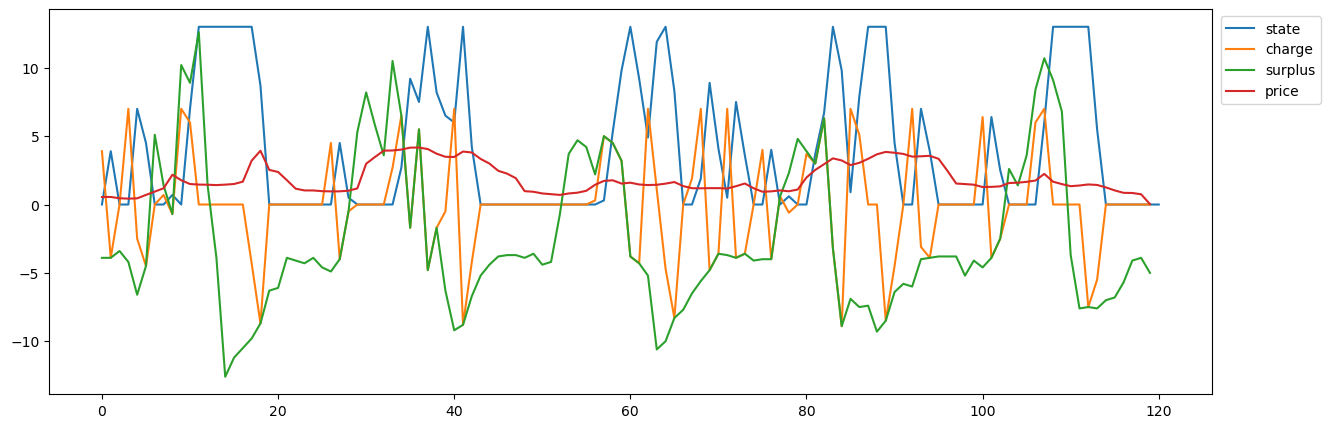

In [28]:
plt.plot(battery_state.value, label = 'state')
plt.plot(charge.value, label = 'charge')

plt.plot(production-consumption,label='surplus')
plt.plot(price*10,label='price')

plt.legend(bbox_to_anchor = (1.1,1.0))
plt.show()

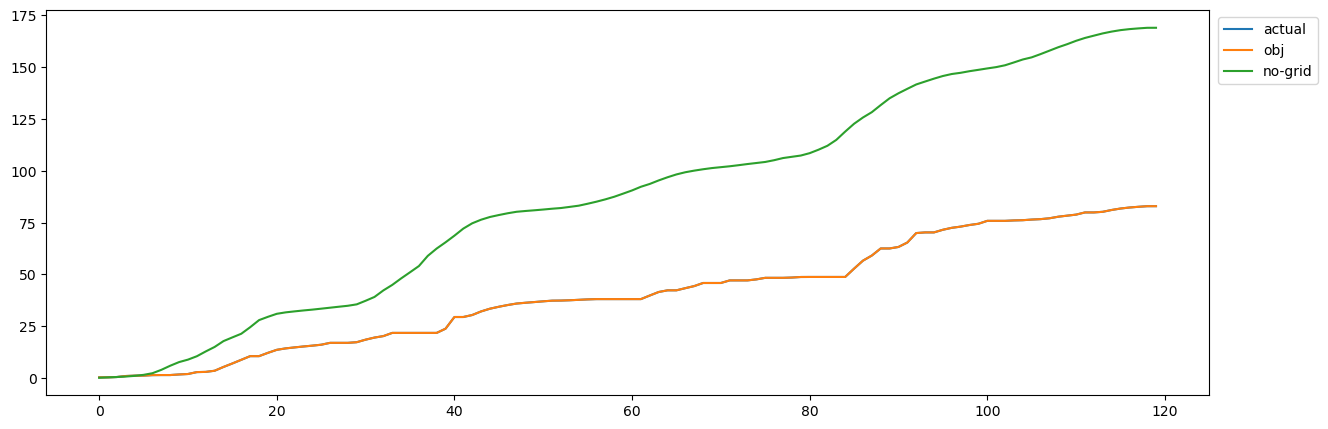

In [30]:
no_grid = [consumption[i]*price[i] for i in range(len(price))]
no_grid_cumm = [np.sum(no_grid[:i]) for i in range(1,len(price)+1)]

plt.plot(l,label='actual')
plt.plot(costs,label='obj')
plt.plot(no_grid_cumm,label='no-grid')

plt.legend(bbox_to_anchor = (1.1,1.0))
plt.show()

In [19]:
df = pd.DataFrame()
df['Charge'] = charge.value
df['Bat. State'] = battery_state[:len(charge.value)].value
df['Surplus'] = production-consumption
df['Price'] = price
df['Costs'] = costs
df['Act. Costs'] = l
df = df.round(2)

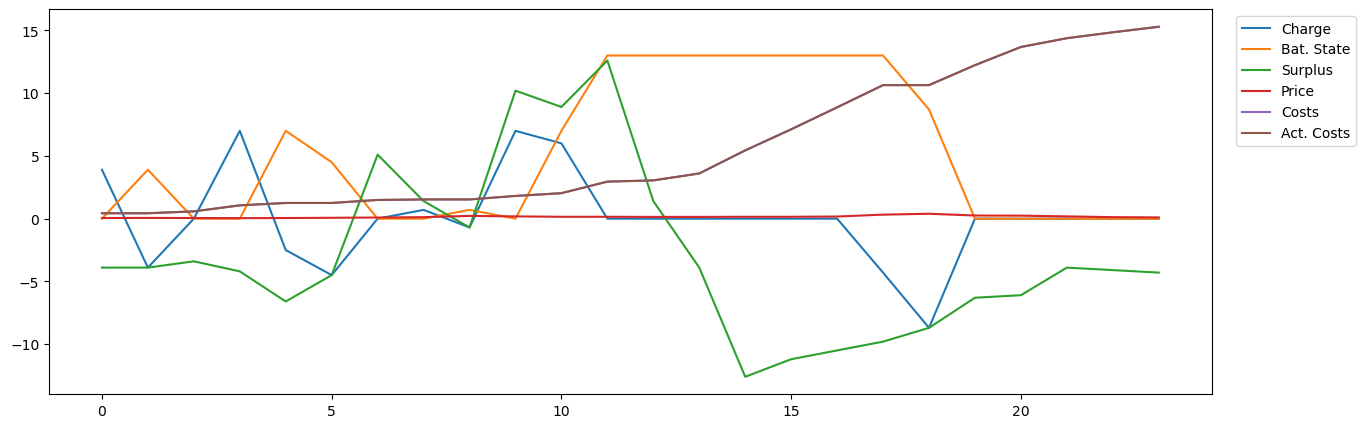

In [33]:
df[:24].plot()
plt.legend(bbox_to_anchor = (1.13,1.0))
plt.show()